In [216]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
import scipy.cluster.hierarchy as sch
import seaborn as sns
df_global = pd.read_csv('../Data/global.csv', encoding='ISO-8859-1')
df_without_norm = pd.read_csv('../Data/global_preprocessed_without_onehot_and_norm.csv')
df = pd.read_csv('../Data/global_preprocessed_without_onehot.csv', encoding='ISO-8859-1')
#df_without_norm = df_without_norm[:df_without_norm.shape[0]//10]
#df = df[:df.shape[0]//10]

dfh = df.sample(frac=0.1)
df_without_normh = df_without_norm[:df_without_norm.shape[0]//10]
#df = df[:df.shape[0]//10]
#df_without_norm = df_without_norm[:df_without_norm.shape[0]//10]

C:\Users\Admin\AppData\Local\Temp\ipykernel_18420\3402666694.py:9: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df_global = pd.read_csv('../Data/global.csv', encoding='ISO-8859-1')


In [217]:
df_global.rename(columns={'gname': 'gname_txt'}, inplace=True)
df_global['gname'] = pd.factorize(df_global['gname_txt'])[0]
attacktype_dict = dict(zip(df_global['attacktype1'], df_global['attacktype1_txt']))
targettype_dict = dict(zip(df_global['targtype1'], df_global['targtype1_txt']))
region_dict = dict(zip(df_global['region'], df_global['region_txt']))
gname_dict = dict(zip(df_global['gname'], df_global['gname_txt']))

In [218]:
df

,iyear,extended,region,nkill,nwound,attacktype1,nperps,suicide,success,gname,targtype1
0,0.0,0,2,0.014286,0.000000,1,0.077519,0,1,0,14
1,0.0,0,1,0.000000,0.000000,6,0.124031,0,1,1,7
2,0.0,0,5,0.014286,0.000000,1,0.077519,0,1,2,10
3,0.0,0,8,0.000000,0.000000,3,0.077519,0,1,2,7
4,0.0,0,4,0.000000,0.000000,7,0.077519,0,1,2,7
...,...,...,...,...,...,...,...,...,...,...,...
169971,1.0,0,11,0.014286,0.019608,2,0.077519,0,1,2656,4
169972,1.0,0,10,0.028571,0.068627,3,0.077519,0,1,592,4
169973,1.0,0,5,0.000000,0.000000,7,0.077519,0,1,2926,14
169974,1.0,0,6,0.000000,0.000000,3,0.077519,0,0,2,2


GridSearch for KMeans clustering

In [219]:
# Define the parameter grid
k_values = range(2, 14)   

# Store silhouette scores and k values
silhouette_scores = []
k_values_used = []
kmeans_array = []
# Perform "Grid Search"
for k in k_values:
    print("K: " + str(k))
    kmeans_i = KMeans(n_clusters=k, random_state=0, n_init='auto', max_iter=100)
    kmeans_i.fit(df)
    score = silhouette_score(df, kmeans_i.labels_,  sample_size=1000)
    silhouette_scores.append(score)
    kmeans_array.append(kmeans_i)
    k_values_used.append(k)

K: 2
K: 3
K: 4
K: 5
K: 6
K: 7
K: 8
K: 9
K: 10
K: 11
K: 12
K: 13


Best k: 2


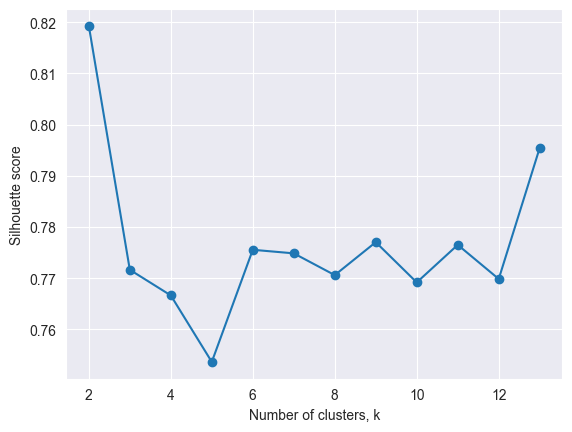

In [220]:
# Determine the best k
best_k = k_values_used[silhouette_scores.index(max(silhouette_scores))]
kmeans = kmeans_array[silhouette_scores.index(max(silhouette_scores))]
print('Best k:', best_k)

# Plot
plt.plot(k_values_used, silhouette_scores, marker='o')
plt.xlabel("Number of clusters, k")
plt.ylabel("Silhouette score")
plt.show()

In [221]:
df['KMeans_labels'] = kmeans.labels_
df_without_norm['KMeans_labels'] = kmeans.labels_

In [222]:
eps_vals = np.linspace(0.3, 1.7, 3)
min_samples_vals = [10]

best_score = -1
best_eps = None
best_dbscan = None
best_min_samples = None


GridSearch for DBSCAN clustering

In [223]:
# DBSCAN clustering
for eps in eps_vals:
    print("Eps: " + str(eps))
    for min_samples in min_samples_vals:
        print("Min samples: " + str(min_samples))
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        
        # Fit the model
        labels = dbscan.fit_predict(df)
        
        # Ignore cases where the clustering resulted in only one cluster or noise
        if len(np.unique(labels)) > 1:
            score = silhouette_score(df, labels, sample_size=1000)
            
            # If the silhouette score is better, store these parameters as the best
            if score > best_score:
                best_dbscan = dbscan
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

Eps: 0.3
Min samples: 10
Eps: 1.0
Min samples: 10
Eps: 1.7
Min samples: 10


Best params for DBSCAN clustering

In [224]:
print("Best eps: " + str(best_eps))
print("Best score: " + str(best_score))
print("Best min samples: " + str(best_min_samples))

Best eps: 0.3
Best score: 0.17864323670168042
Best min samples: 10


In [225]:
dbscan = best_dbscan
df['DBSCAN_labels'] = dbscan.labels_
df_without_norm['DBSCAN_labels'] = dbscan.labels_

Hierarchical clustering

In [226]:
try:
    # Hierarchical clustering
    agg_clustering = AgglomerativeClustering(n_clusters=best_k)
    agg_clustering.fit(dfh)
    dfh['Hierarchical_labels'] = agg_clustering.labels_
    df_without_normh['Hierarchical_labels'] = agg_clustering.labels_
except:
    pass

Evaluation of KMeans, DBSCAN and Hierarchical models

In [227]:
print(f"KMeans silhouette score: {silhouette_score(df, kmeans.labels_, sample_size=1000):.2f}")
print(f"DBSCAN silhouette score: {silhouette_score(df, dbscan.labels_, sample_size=1000):.2f}")
try:
    print(f"Hierarchical silhouette score: {silhouette_score(dfh, agg_clustering.labels_, sample_size=1000):.2f}")
except:
    pass

KMeans silhouette score: 0.69
DBSCAN silhouette score: 0.36
Hierarchical silhouette score: 0.82


In [228]:
# Comparison with true labels
#print(f"KMeans Adjusted Rand Index: {adjusted_rand_score(df, df['KMeans_labels']):.2f}")
#print(f"DBSCAN Adjusted Rand Index: {adjusted_rand_score(df, df['DBSCAN_labels']):.2f}")
#print(f"Hierarchical Adjusted Rand Index: {adjusted_rand_score(df, df['Hierarchical_labels']):.2f}")

KMeans clusters

In [229]:
df_KMeans = df_without_norm.copy()
for label in ["attacktype1", "targtype1", "region", "gname"]:    
    mode_df = df_KMeans.groupby('KMeans_labels')[label].agg(pd.Series.mode).reset_index()
    df_KMeans = pd.merge(df_KMeans, mode_df, on='KMeans_labels', how='left')
    df_KMeans.drop(label + '_x', axis=1, inplace=True)
    df_KMeans.rename(columns={label + '_y': label}, inplace=True)

In [230]:
df_KMeans = df_KMeans.groupby("KMeans_labels").mean()
df_KMeans["targtype1"] = df_KMeans['targtype1'].map(targettype_dict)
df_KMeans["region"] = df_KMeans['region'].map(region_dict)
df_KMeans["gname"] = df_KMeans['gname'].map(gname_dict)
df_KMeans["attacktype1"] = df_KMeans['attacktype1'].map(attacktype_dict)
df_KMeans

,iyear,extended,nkill,nwound,nperps,suicide,success,DBSCAN_labels,attacktype1,targtype1,region,gname
KMeans_labels,,,,,,,,,,,,
0,1999.886375,0.030101,1.305771,2.002608,1.916840,0.018627,0.882676,416.653135,Bombing/Explosion,Private Citizens & Property,Middle East & North Africa,Unknown
1,2010.989548,0.092456,3.099869,3.305201,2.731657,0.081774,0.900914,945.216613,Bombing/Explosion,Private Citizens & Property,South Asia,Association of Demobilized Armed Forces


In [231]:
df_extended = df_without_norm.copy()
for label in ["attacktype1", "targtype1", "region", "gname"]:    
    mode_df = df_extended.groupby('KMeans_labels')[label].agg(pd.Series.mode).reset_index()
    df_extended = pd.merge(df_extended, mode_df, on='KMeans_labels', how='left')
    df_extended.drop(label + '_x', axis=1, inplace=True)
    df_extended.rename(columns={label + '_y': label}, inplace=True)

Showing extended/not extended classes

In [232]:
df_extended = df_extended.groupby("extended").mean()
df_extended["targtype1"] = df_extended['targtype1'].map(targettype_dict)
df_extended["region"] = df_extended['region'].map(region_dict)
df_extended["gname"] = df_extended['gname'].map(gname_dict)
df_extended["attacktype1"] = df_extended['attacktype1'].map(attacktype_dict)
df_extended

,iyear,nkill,nwound,nperps,suicide,success,KMeans_labels,DBSCAN_labels,attacktype1,targtype1,region,gname
extended,,,,,,,,,,,,
0,2002.462217,1.771707,2.415021,2.075584,0.036195,0.882128,0.243113,542.599472,Bombing/Explosion,Private Citizens & Property,NaN,NaN
1,2008.143642,1.609712,0.687284,3.150415,0.005112,0.995272,0.513227,740.855974,Bombing/Explosion,Private Citizens & Property,NaN,NaN


Showing suicide/not suicide classes

In [233]:
df_extended = df_without_norm.copy()
for label in ["attacktype1", "targtype1", "region", "gname"]:    
    mode_df = df_extended.groupby('KMeans_labels')[label].agg(pd.Series.mode).reset_index()
    df_extended = pd.merge(df_extended, mode_df, on='KMeans_labels', how='left')
    df_extended.drop(label + '_x', axis=1, inplace=True)
    df_extended.rename(columns={label + '_y': label}, inplace=True)
df_extended = df_extended.groupby("suicide").mean()
df_extended["targtype1"] = df_extended['targtype1'].map(targettype_dict)
df_extended["region"] = df_extended['region'].map(region_dict)
df_extended["gname"] = df_extended['gname'].map(gname_dict)
df_extended["attacktype1"] = df_extended['attacktype1'].map(attacktype_dict)
df_extended

,iyear,extended,nkill,nwound,nperps,success,KMeans_labels,DBSCAN_labels,attacktype1,targtype1,region,gname
suicide,,,,,,,,,,,,
0,2002.385873,0.047450,1.551250,1.969415,2.138352,0.889051,0.243102,533.699275,Bombing/Explosion,Private Citizens & Property,NaN,NaN
1,2012.105602,0.006769,7.678287,12.499577,1.756135,0.839736,0.601117,1052.260281,Bombing/Explosion,Private Citizens & Property,NaN,NaN


Showing success/not success classes

In [234]:
df_extended = df_without_norm.copy()
for label in ["attacktype1", "targtype1", "region", "gname"]:    
    mode_df = df_extended.groupby('KMeans_labels')[label].agg(pd.Series.mode).reset_index()
    df_extended = pd.merge(df_extended, mode_df, on='KMeans_labels', how='left')
    df_extended.drop(label + '_x', axis=1, inplace=True)
    df_extended.rename(columns={label + '_y': label}, inplace=True)
df_extended = df_extended.groupby("success").mean()
df_extended["targtype1"] = df_extended['targtype1'].map(targettype_dict)
df_extended["region"] = df_extended['region'].map(region_dict)
df_extended["gname"] = df_extended['gname'].map(gname_dict)
df_extended["attacktype1"] = df_extended['attacktype1'].map(attacktype_dict)
df_extended

,iyear,extended,nkill,nwound,nperps,suicide,KMeans_labels,DBSCAN_labels,attacktype1,targtype1,region,gname
success,,,,,,,,,,,,
0,2005.607676,0.001932,0.587363,0.584386,1.611802,0.049452,0.224752,636.080992,Bombing/Explosion,Private Citizens & Property,NaN,NaN
1,2002.357604,0.051636,1.913675,2.557815,2.190232,0.032899,0.259458,541.016098,Bombing/Explosion,Private Citizens & Property,NaN,NaN


In [235]:
df_attack = df_without_norm.copy()
df_attack["attacktype1"] = df_attack['attacktype1'].map(attacktype_dict)
for label in ["targtype1", "region", "gname"]:    
    mode_df = df_attack.groupby('KMeans_labels')[label].agg(pd.Series.mode).reset_index()
    df_attack = pd.merge(df_attack, mode_df, on='KMeans_labels', how='left')
    df_attack.drop(label + '_x', axis=1, inplace=True)
    df_attack.rename(columns={label + '_y': label}, inplace=True)

Showing classes by attack type

In [236]:
df_attack = df_attack.groupby("attacktype1").mean()
df_attack["targtype1"] = df_attack['targtype1'].map(targettype_dict)
df_attack["region"] = df_attack['region'].map(region_dict)
df_extended["gname"] = df_extended['gname'].map(gname_dict)
df_attack

,iyear,extended,nkill,nwound,nperps,suicide,success,KMeans_labels,DBSCAN_labels,targtype1,region,gname
attacktype1,,,,,,,,,,,,
Armed Assault,2003.733543,0.011915,2.983737,1.633658,3.132303,0.001288,0.944261,0.302230,627.310925,Private Citizens & Property,NaN,597.393286
Assassination,1996.196446,0.005907,1.286046,0.698660,1.566080,0.013606,0.756671,0.139753,373.161006,Private Citizens & Property,NaN,277.313785
Bombing/Explosion,2003.646370,0.001227,1.465059,3.548687,1.375713,0.065750,0.876684,0.219844,543.239605,Private Citizens & Property,NaN,435.092609
Facility/Infrastructure Attack,2000.637765,0.007266,0.214749,0.299980,3.208464,0.000098,0.943637,0.229674,512.894148,Private Citizens & Property,NaN,454.457777
Hijacking,1999.233025,0.229938,0.958333,0.560185,3.168210,0.012346,0.876543,0.283951,44.283951,Private Citizens & Property,NaN,561.382716
Hostage Taking (Barricade Incident),1994.685654,0.099156,2.177215,2.095992,6.952532,0.051688,0.991561,0.262658,138.234177,Private Citizens & Property,NaN,519.436709
Hostage Taking (Kidnapping),2005.384695,0.632239,1.180279,0.343437,3.193938,0.001965,0.977453,0.437927,694.667602,Private Citizens & Property,NaN,864.715876
Unarmed Assault,2003.848643,0.002088,0.522965,4.514614,3.090814,0.002088,0.866388,0.353862,316.094990,Private Citizens & Property,NaN,699.108559
Unknown,2004.339771,0.013974,3.661956,1.809075,3.277909,0.000314,0.831214,0.514366,723.821793,Private Citizens & Property,NaN,1015.301931


DBSCAN clusters

In [237]:
df_DBSCAN = df_without_norm.copy()

In [238]:
for label in ["attacktype1", "targtype1", "region", "gname"]:    
    mode_df = df_DBSCAN.groupby('DBSCAN_labels')[label].agg(pd.Series.mode).reset_index()
    df_DBSCAN = pd.merge(df_DBSCAN, mode_df, on='DBSCAN_labels', how='left')
    df_DBSCAN.drop(label + '_x', axis=1, inplace=True)
    df_DBSCAN.rename(columns={label + '_y': label}, inplace=True)

In [239]:
df_DBSCAN = df_DBSCAN.groupby("DBSCAN_labels").mean(numeric_only=False)
#df_DBSCAN["targtype1"] = df_DBSCAN['targtype1'].map(targettype_dict)
#df_DBSCAN["region"] = df_DBSCAN['region'].map(region_dict)
#df_DBSCAN["gname"] = df_DBSCAN['gname'].map(gname_dict)
#df_DBSCAN["attacktype1"] = df_DBSCAN['attacktype1'].map(attacktype_dict)
df_DBSCAN

,iyear,extended,nkill,nwound,nperps,suicide,success,KMeans_labels,attacktype1,targtype1,region,gname
DBSCAN_labels,,,,,,,,,,,,
-1,1998.962595,0.083057,2.310729,3.007532,3.513558,0.044171,0.832176,0.427003,3.0,14.0,6.0,2.0
0,1983.275229,0.000000,0.082569,0.678899,1.027523,0.000000,1.000000,0.000000,3.0,7.0,8.0,2.0
1,1970.176471,0.000000,0.705882,0.411765,1.294118,0.000000,1.000000,0.000000,2.0,3.0,1.0,3.0
2,1977.133333,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.0,21.0,1.0,2.0
3,1970.285714,0.000000,0.000000,0.047619,1.142857,0.000000,1.000000,0.000000,7.0,4.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1980,2017.000000,0.000000,0.000000,0.000000,1.280000,0.000000,1.000000,1.000000,7.0,2.0,6.0,3432.0
1981,2017.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,7.0,3.0,6.0,3432.0
1982,2017.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,7.0,19.0,8.0,3434.0


Hierarc clusters

In [240]:
try:
    df_Hierarc = df_without_normh
    for label in ["attacktype1", "targtype1", "region", "gname"]:    
        mode_df = df_Hierarc.groupby('Hierarchical_labels')[label].agg(pd.Series.mode).reset_index()
        df_Hierarc = pd.merge(df_Hierarc, mode_df, on='Hierarchical_labels', how='left')
        df_Hierarc.drop(label + '_x', axis=1, inplace=True)
        df_Hierarc.rename(columns={label + '_y': label}, inplace=True)
except:
    pass

In [241]:
try:
    df_Hierarc = df_Hierarc.groupby("Hierarchical_labels").mean(numeric_only=False)
    #df_Hierarc["targtype1"] = df_Hierarc['targtype1'].map(targettype_dict)
    #df_Hierarc["region"] = df_Hierarc['region'].map(region_dict)
    #df_Hierarc["gname"] = df_Hierarc['gname'].map(gname_dict)
    #df_Hierarc["attacktype1"] = df_Hierarc['attacktype1'].map(attacktype_dict)
    #print(df_Hierarc)
except:
    pass
df_Hierarc

,iyear,extended,region,nkill,nwound,attacktype1,nperps,suicide,success,gname,targtype1
0,1970,0,2,1.0,0.0,1,1.0,0,1,0,14
1,1970,0,1,0.0,0.0,6,7.0,0,1,1,7
2,1970,0,5,1.0,0.0,1,1.0,0,1,2,10
3,1970,0,8,0.0,0.0,3,1.0,0,1,2,7
4,1970,0,4,0.0,0.0,7,1.0,0,1,2,7
...,...,...,...,...,...,...,...,...,...,...,...
16992,1983,0,10,0.0,0.0,3,3.0,0,1,36,4
16993,1983,0,11,5.0,0.0,9,1.0,0,1,530,19
16994,1983,0,1,0.0,0.0,4,1.0,0,1,101,6
16995,1983,0,10,0.0,0.0,2,1.0,0,1,36,14


C:\Users\Admin\AppData\Local\Temp\ipykernel_18420\272779205.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0][0].scatter(df[label1], df[label2], cmap='viridis')


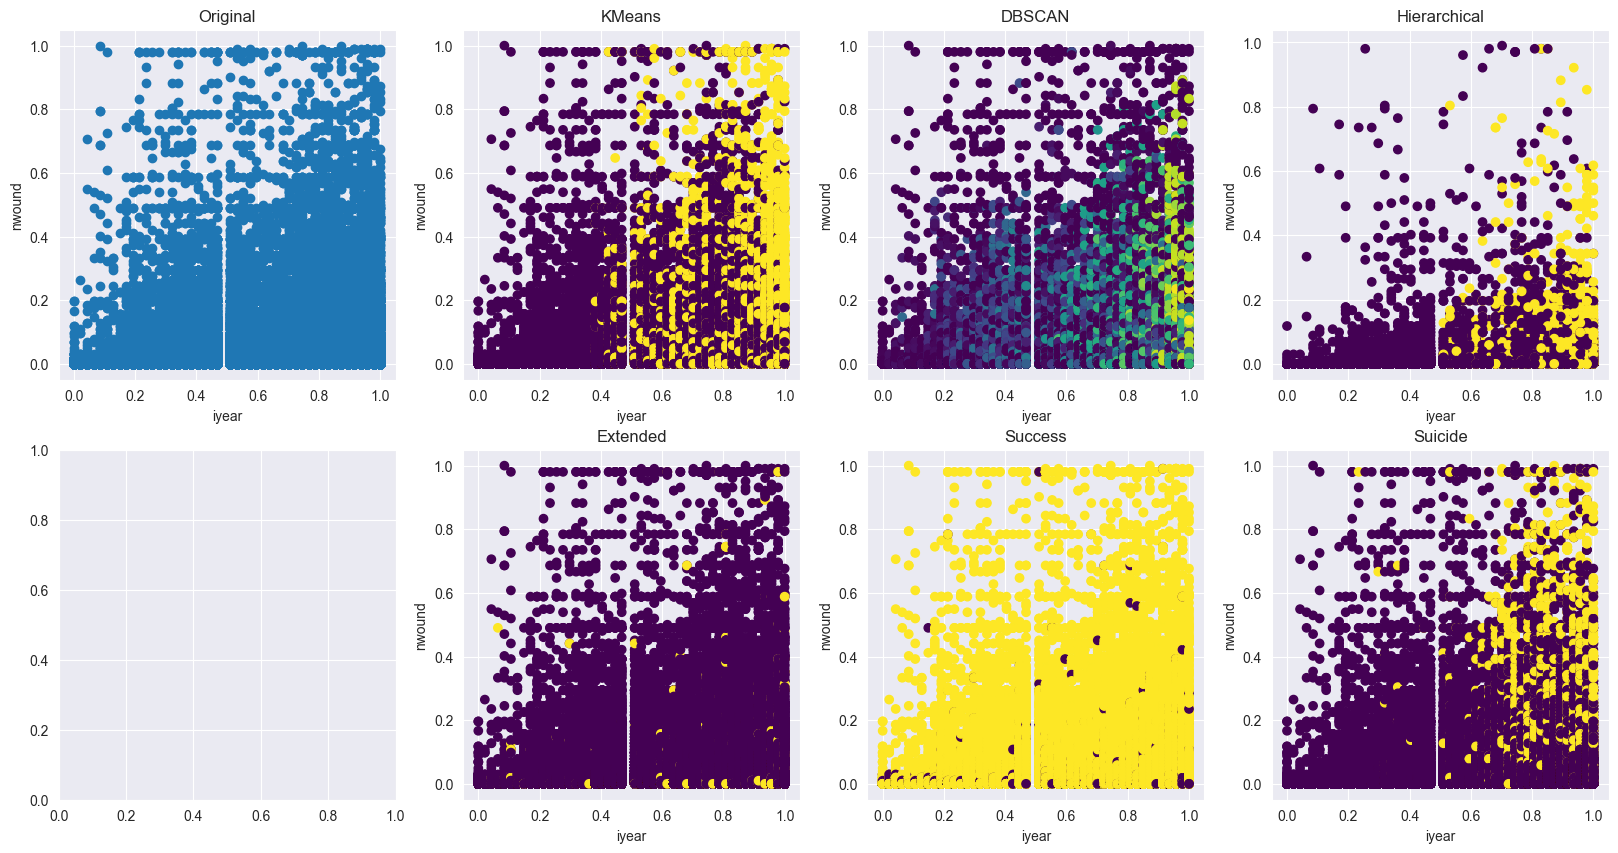

In [244]:
label1 = "iyear"
label2 = "nwound"
# Visualization
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

# cmap parameter added as 'viridis' to scatter function.
ax[0][0].scatter(df[label1], df[label2], cmap='viridis')
ax[0][0].set_title('Original')
ax[0][0].set_xlabel(label1)
ax[0][0].set_ylabel(label2)

ax[0][1].scatter(df[label1], df[label2], c=df['KMeans_labels'], cmap='viridis')
ax[0][1].set_title('KMeans')
ax[0][1].set_xlabel(label1)
ax[0][1].set_ylabel(label2)

ax[0][2].scatter(df[label1], df[label2], c=df['DBSCAN_labels'], cmap='viridis')
ax[0][2].set_title('DBSCAN')
ax[0][2].set_xlabel(label1)
ax[0][2].set_ylabel(label2)

try:
    ax[0][3].scatter(dfh[label1], dfh[label2], c=dfh['Hierarchical_labels'], cmap='viridis')
    ax[0][3].set_title('Hierarchical')
    ax[0][3].set_xlabel(label1)
    ax[0][3].set_ylabel(label2)
except:
    pass

ax[1][1].scatter(df[label1], df[label2], c=df['extended'], cmap='viridis')
ax[1][1].set_title('Extended')
ax[1][1].set_xlabel(label1)
ax[1][1].set_ylabel(label2)

ax[1][2].scatter(df[label1], df[label2], c=df['success'], cmap='viridis')
ax[1][2].set_title('Success')
ax[1][2].set_xlabel(label1)
ax[1][2].set_ylabel(label2)

ax[1][3].scatter(df[label1], df[label2], c=df['suicide'], cmap='viridis')
ax[1][3].set_title('Suicide')
ax[1][3].set_xlabel(label1)
ax[1][3].set_ylabel(label2)

plt.show()

In [243]:
print(len(set(df['KMeans_labels'])), len(set(df['DBSCAN_labels'])), len(set(dfh['Hierarchical_labels'])))

2 1986 2
